<h1> Satellite Precipitation Data Analysis</h1>

<p> This project's goal is to analyze PERSIANN (Precipitation Estimation from Remotely Sensed Information using Artificial Neural Networks) 
dataset provided by CHRS Data Portal. </p>

In [2]:
## Data domain

## NCOLS and NROWS are the number of columns and rows in the raster defined by the ASCII file
N_COLS = 42
N_ROWS = 25

## XLLCORNER and YLLCORNER are the coordinates of the lower left corner of the lower left cell
XLL_CORNER = 14.000
YLL_CORNER = 49.000

## CELLSIZE is the cell size of the raster.
CELL_SIZE = 0.25

NO_DATA_VALUE = -99
UNIT = "mm"

<h2>Exploring the data</h2>

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
example_satellite_image_path = "./data/PERSIANN_6h2019011706.tif"

example_img = np.asarray(Image.open(example_satellite_image_path))
print("Data (tiff image) shape:", example_img.shape)

Data (tiff image) shape: (25, 42)


In [4]:
print("Data as array (row nr 10):", example_img[10])

Data as array (row nr 10): [-99.   -99.     0.     0.     0.     0.38   0.36   0.35   0.36   0.36
   0.63   0.36   0.8    0.59   0.8    0.78   0.25   0.25   0.     0.
   0.     0.     0.     0.     0.     0.     0.24   0.22   0.21   1.23
   1.02   0.81   1.35   1.64   1.56   1.26   0.81   0.56   0.75 -99.
 -99.   -99.  ]


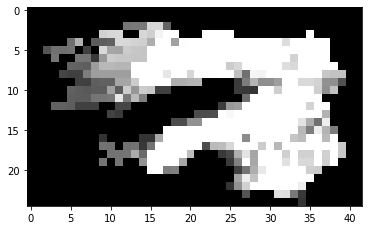

In [5]:
from matplotlib.colors import NoNorm
plt.imshow(example_img, cmap='gray', norm=NoNorm())

<h2>Loading the data</h2>

In [6]:
import glob, os
import re
from datetime import datetime

data_path = "./data"
data_datetime_pattern = re.compile(r'^.*PERSIANN_6h(\d{10}).tif$')

def getDateTimeFromFileName(file_name):
    date_time_string = data_datetime_pattern.search(file_name).group(1)
    return datetime.strptime(date_time_string, '%Y%m%d%H')

def getTiffFileAsArray(file_name):
    return np.asarray(Image.open(file_name))

def getDataWithCoordinates(data_array):
    data_with_coordinates = {}
    for index, value in np.ndenumerate(data_array):
        i, j = index
        y_left_down = YLL_CORNER + CELL_SIZE * (N_ROWS - 1 - i)
        x_left_down = XLL_CORNER + CELL_SIZE * j
        coordinates = {
            'left_down_corner': {'lng': x_left_down, 'lat': y_left_down},
            'left_upper_corner': {'lng': x_left_down, 'lat': y_left_down - CELL_SIZE},
            'right_down_corner': {'lng': x_left_down + CELL_SIZE, 'lat': y_left_down},
            'right_upper_corner': {'lng': x_left_down + CELL_SIZE, 'lat': y_left_down - CELL_SIZE}
        }
        data_with_coordinates[index] = { 'value': value, 'coordinates': coordinates }
    return data_with_coordinates
        

# get all files containing data
all_files = glob.glob(os.path.join(data_path, '*.tif'), recursive=False)

# load data into array of tuples
data = [(getDateTimeFromFileName(f), getDataWithCoordinates(getTiffFileAsArray(f))) for f in all_files]


In [7]:
# show example value and coordinates for one point in the middle of Poland
data[13][1].get((11,18))


{'value': 0.32,
 'coordinates': {'left_down_corner': {'lng': 18.5, 'lat': 52.25},
  'left_upper_corner': {'lng': 18.5, 'lat': 52.0},
  'right_down_corner': {'lng': 18.75, 'lat': 52.25},
  'right_upper_corner': {'lng': 18.75, 'lat': 52.0}}}

# Display data

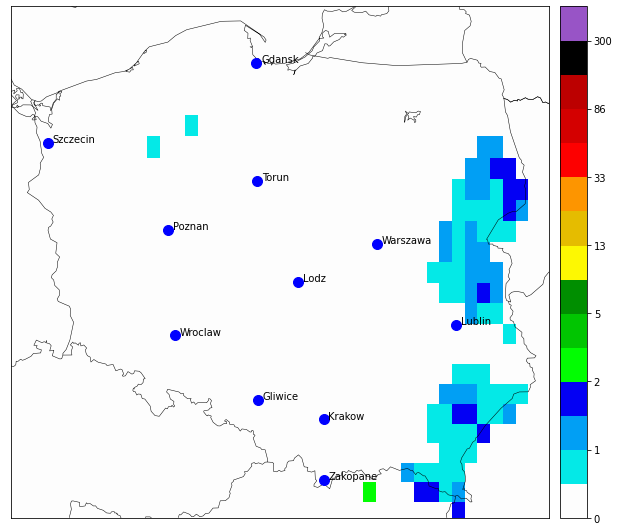

In [9]:
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

cities = {
    'Gdansk': {'pos': (54.36, 18.64)},
    'Gliwice': {'pos': (50.31, 18.67)},
    'Krakow': {'pos': (50.06, 19.96)},
    'Lodz': {'pos': (51.77, 19.46)},
    'Lublin': {'pos': (51.24, 22.57)},
    'Poznan': {'pos': (52.4, 16.9)},
    'Szczecin': {'pos': (53.43, 14.53)},
    'Torun': {'pos': (52.9823, 18.6552)},
    'Wroclaw': {'pos': (51.11, 17.03)},
    'Zakopane': {'pos': (49.29, 19.96)},
    'Warszawa': {'pos': ( 52.2297700, 21.0117800 )},
}

# Colorbar with NSW Precip colors
nws_precip_colors = [
    "#fdfdfd",  # 0.00 - 0.01 mm
    "#04e9e7",  # 0.01 - 0.10 mm
    "#019ff4",  # 0.10 - 0.25 mm
    "#0300f4",  # 0.25 - 0.50 mm
    "#02fd02",  # 0.50 - 0.75 mm
    "#01c501",  # 0.75 - 1.00 mm
    "#008e00",  # 1.00 - 1.50 mm
    "#fdf802",  # 1.50 - 2.00 mm
    "#e5bc00",  # 2.00 - 2.50 mm
    "#fd9500",  # 2.50 - 3.00 mm
    "#fd0000",  # 3.00 - 4.00 mm
    "#d40000",  # 4.00 - 5.00 mm
    "#bc0000",  # 5.00 - 6.00 mm
    "#000000",  # 6.00 - 8.00 mm
    "#9854c6",  # 8.00 - 10.00 mm
]

levels = [
    0.,
    0.5,
    1,
    1.5,
    2,
    3,
    5,
    7,
    13,
    20,
    33,
    53,
    86,
    139,
    300,
    500,
]

precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)

def plot_conus():
    # map max and min lats (Poland)
    lat_min, lat_max = 48.8, 55.0
    lon_min, lon_max = 13.8, 24.4

    # size of result image
    fig = plt.figure(figsize=(10.0, 9.0))

    # margins
    plt.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10, wspace=0.15, hspace=0.05)
    m = Basemap(
        resolution='i',
        projection='merc',
        llcrnrlat=lat_min,
        urcrnrlat=lat_max,
        llcrnrlon=lon_min,
        urcrnrlon=lon_max)
    m.drawcountries(linewidth=0.5)
    m.drawcoastlines(linewidth=0.5)
    
    # draw cities
    for name, data in cities.items():
        # coordinates in reversed order
        x, y = m(data['pos'][1], data['pos'][0])

        # drawing a symbol
        m.plot(x, y, 'bo', markersize=10)

        # draw a label with offset
        plt.text(x + 10000, y + 1000, name)
    
    return m

def countColumns(input):
    columns = 0
    for key, value in input.items():
        if (key[0] == 0):
            columns += 1
            continue
        break
    
    return columns

def countRows(input):
    rows = 0
    for key, value in input.items():
        if (key[1] == 0):
            rows += 1
            continue
    
    return rows

def getData(input):
    numRows = countRows(input)
    numColumns = countColumns(input)
    
    lats = np.empty((numRows + 1, numColumns + 1), dtype='float')
    longs = np.empty((numRows + 1, numColumns + 1), dtype='float')
    precip_data = np.empty((numRows, numColumns), dtype='float')
    
    for column in range(numColumns):
        for row in range(numRows):
            value = input[(row, column)]['value']
            if value < 0.01:
                value = 0.0
            precip_data[row][column] = value
            
            lats[row + 1][column] = input[(row, column)]['coordinates']['left_upper_corner']['lat']
            longs[row + 1][column] = input[(row, column)]['coordinates']['left_upper_corner']['lng']
            
            lats[row + 1][column + 1] = input[(row, column)]['coordinates']['right_upper_corner']['lat']
            longs[row + 1][column + 1] = input[(row, column)]['coordinates']['right_upper_corner']['lng']
            
            lats[row][column] = input[(row, column)]['coordinates']['left_down_corner']['lat']
            longs[row][column] = input[(row, column)]['coordinates']['left_down_corner']['lng']
            
            lats[row][column + 1] = input[(row, column)]['coordinates']['right_down_corner']['lat']
            longs[row][column + 1] = input[(row, column)]['coordinates']['right_down_corner']['lng']
            
    return lats, longs, precip_data
            
lats, longs, precip_data = getData(data[8][1])

m = plot_conus()
norm = matplotlib.colors.BoundaryNorm(levels, 15)
cax = m.pcolormesh(longs, lats, precip_data, latlon=True, norm=norm, cmap=precip_colormap)
m.colorbar(cax)